# Moosic

## 1 Data

### 1.1 Libraries

In [1]:
import ctypes # beeper
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import plotly
import numpy as np
import plotly.graph_objects as go
import random
import seaborn as sns

from sklearn import set_config
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, pairwise_distances, silhouette_score
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, PowerTransformer, QuantileTransformer, RobustScaler, StandardScaler

from ydata_profiling import ProfileReport

set_config(transform_output="pandas")

### 1.2 Data

In [2]:
file_id = "12RcGLcvv-UjJjb3wL_yL76EiPT2JvB3k" # milos
url = f'https://drive.google.com/uc?export=download&id={file_id}'
songs5000_df = pd.read_csv(url, index_col='id                     ')
songs5000_df.columns = songs5000_df.columns.str.strip()
songs5000_df = songs5000_df[~songs5000_df.index.duplicated(keep='first')]
songs5000_names_df = songs5000_df[['name', 'artist', 'html']]
to_drop = ['Unnamed: 0', 'name', 'artist', 'html', 'type'] # 'duration_ms'?? # Sudeep took out also: key, mode, time_signature
songs5000_df = songs5000_df.drop(columns=to_drop)
songs5000_df = songs5000_df.drop_duplicates(keep='first')

### 1.3 Preprocessing

In [3]:
preprocessing_dict = {
    'danceability': [ # yes
        # {'method': 'none', 'parameters': {}} # the parameters key can be skipped if empty
        {'method': 'standard'}
    ]
    , 'energy': [ # yes
        # {'method': 'quantile'}
        {'method': 'standard'}
    ]
    , 'key': [
        {'method': 'minmax'}
    ]
    , 'loudness': [ # yes
        # {'method': 'robust'}
        # , {'method': 'power'}
        # , {'method': 'minmax', 'parameters': {'feature_range': (0, 1.3)}}
        {'method': 'standard'}
    ]
    , 'mode': [ # yes
        {'method': 'standard'}
    ]
    , 'speechiness': [ # yes
        # {'method': 'robust'}
        # , {'method': 'power'}
        # , {'method': 'minmax', 'parameters': {'feature_range': (-0.4, 1)}}
        {'method': 'standard'}
    ]
    , 'acousticness': [ # yes
        # {'method': 'quantile'}
        {'method': 'standard'}
    ]
    , 'instrumentalness': [ # yes
        # {'method': 'power'}
        # , {'method': 'minmax'}
        # , {'method': 'quantile'}
        {'method': 'standard'}
    ]
    , 'liveness': [ # yes
        # {'method': 'power'}
        # , {'method': 'minmax', 'parameters': {'feature_range': (-0.15, 1)}}
        {'method': 'standard'}
    ]
    , 'valence': [ # yes
        # {'method': 'power'}
        # , {'method': 'minmax'}
        {'method': 'standard'}
    ]
    , 'tempo': [ # yes
        # {'method': 'standard'}
        # , {'method': 'minmax', 'parameters': {'feature_range': (-0.3, 1)}}
        {'method': 'standard'}
    ]
    , 'duration_ms': [
        # {'method': 'function', 'parameters': {'func': np.log1p, 'validate': True}}
        # , {'method': 'minmax', 'parameters': {'feature_range': (-0.4, 1.5)}}
        {'method': 'none'}
    ]
    , 'time_signature': [
        # {'method': 'power'}
        # , {'method': 'minmax'}
        {'method': 'none'}
    ]
}
number_of_components = len(preprocessing_dict)
preprocessing_df = pd.DataFrame(
    [
        (key, method.get('method'), method.get('parameters', {}))
        for key, methods in preprocessing_dict.items()
        if isinstance(methods, list)
        for method in methods
        if isinstance(method, dict)
    ],
    columns=["feature", "method", "parameters"]
)
# preprocessing_df

In [4]:
songs5000_preprocessed_df = songs5000_df.copy()

for i, row in preprocessing_df.iterrows():
    feature = row['feature']
    method = row['method']
    parameters = row['parameters']

    if method == 'function':
        scaler = FunctionTransformer(**parameters).set_output(transform="default")
        songs5000_preprocessed_df[feature] = scaler.fit_transform(songs5000_preprocessed_df[[feature]])
    elif method == 'minmax':
        scaler = MinMaxScaler(**parameters).set_output(transform="pandas")
        songs5000_preprocessed_df[feature] = scaler.fit_transform(songs5000_preprocessed_df[[feature]])
    elif method == 'power':
        transformer = PowerTransformer(**parameters).set_output(transform="pandas")
        songs5000_preprocessed_df[feature] = transformer.fit_transform(songs5000_preprocessed_df[[feature]])
    elif method == 'quantile':
        transformer = QuantileTransformer(**parameters).set_output(transform="pandas")
        songs5000_preprocessed_df[feature] = transformer.fit_transform(songs5000_preprocessed_df[[feature]])
    elif method == 'robust':
        scaler = RobustScaler(**parameters).set_output(transform="pandas")
        songs5000_preprocessed_df[feature] = scaler.fit_transform(songs5000_preprocessed_df[[feature]])
    elif method == 'standard':
        scaler = StandardScaler(**parameters).set_output(transform="pandas")
        songs5000_preprocessed_df[feature] = scaler.fit_transform(songs5000_preprocessed_df[[feature]])

songs5000_preprocessed_df = songs5000_preprocessed_df[['danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]
songs5000_features_df = songs5000_df[['danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']].copy()
number_of_components = len(songs5000_preprocessed_df.columns)

### 1.4 Plot

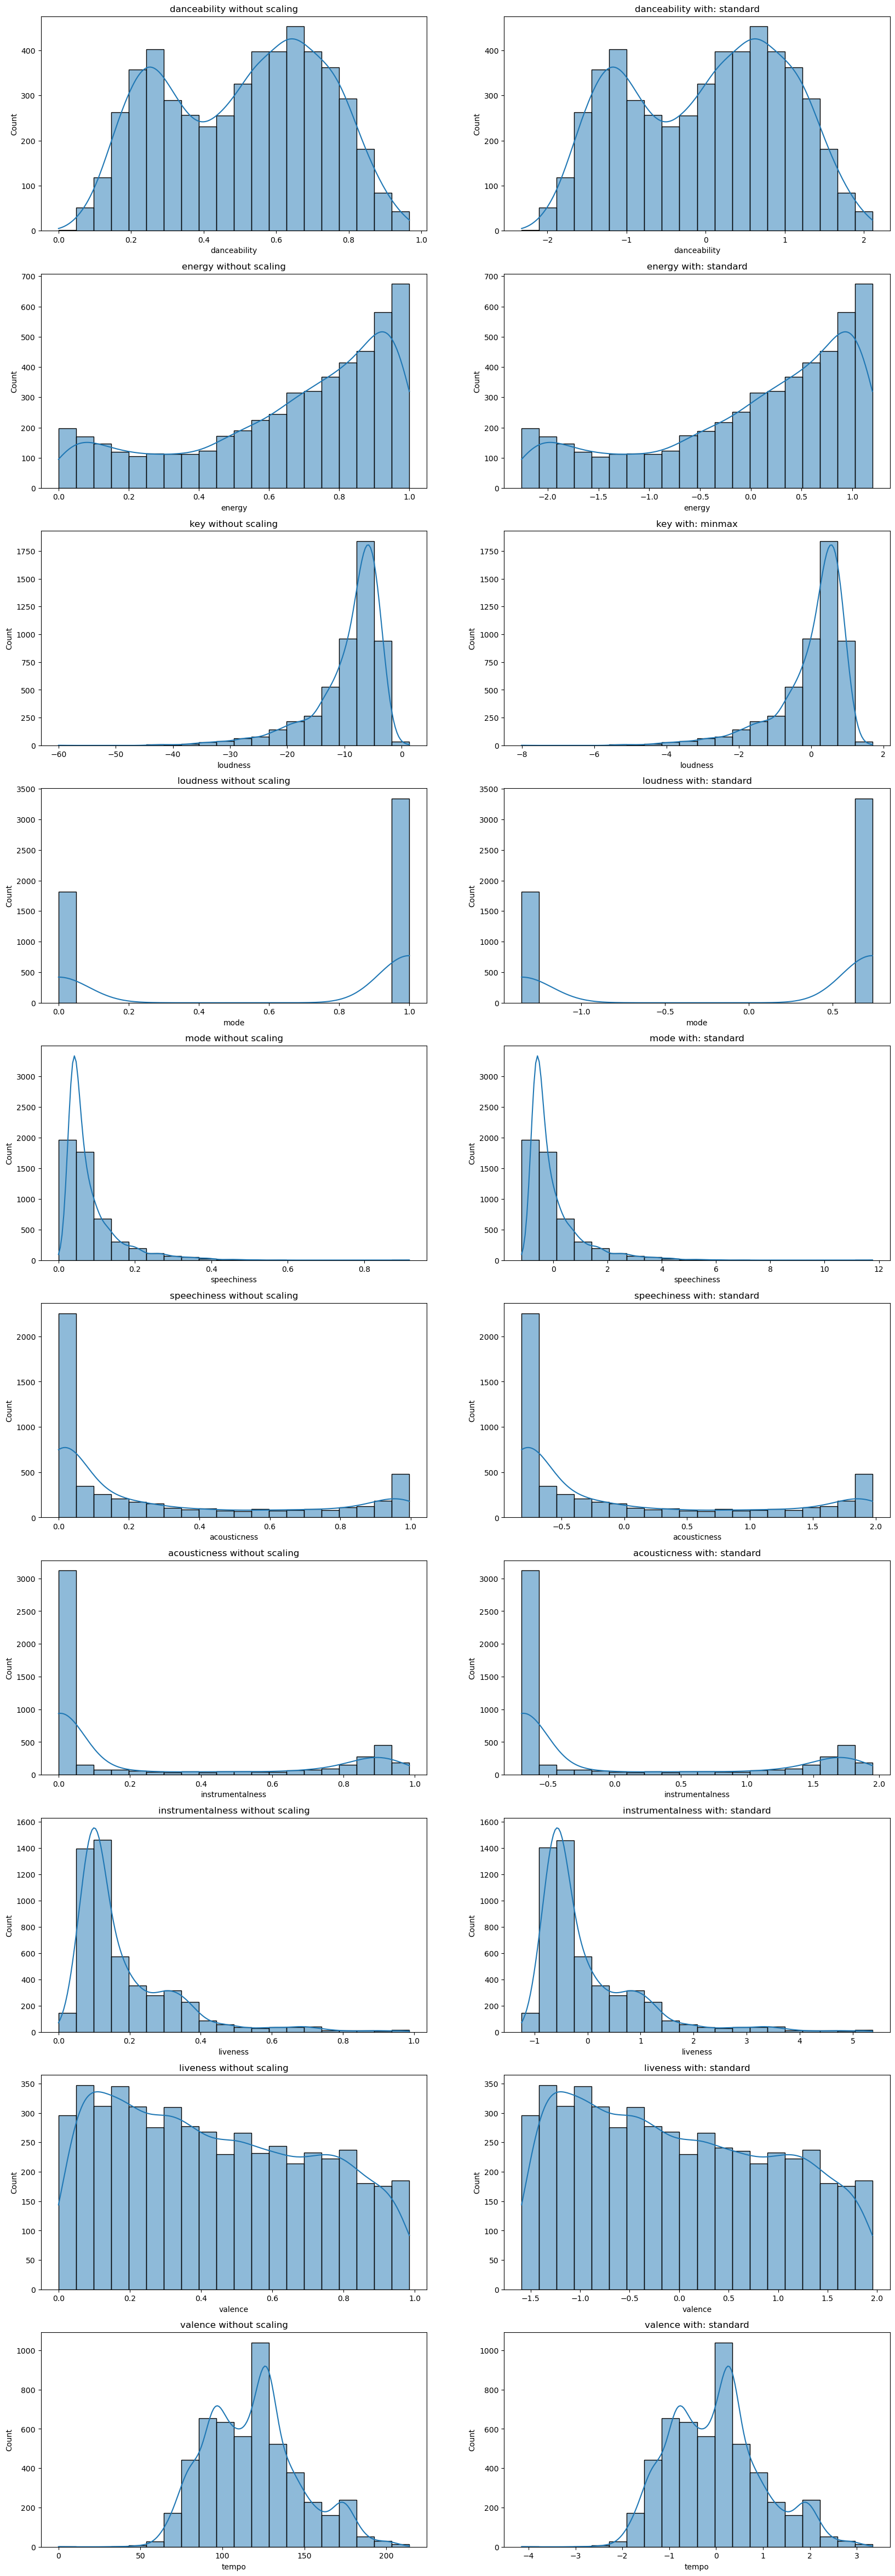

In [5]:
fig, ax = plt.subplots(number_of_components, 2, figsize=(20, 60))

for i in range(ax.shape[0]):
    sns.histplot(data=songs5000_features_df.iloc[:, i], bins=20, kde=True, ax=ax[i, 0]);
    sns.histplot(data=songs5000_preprocessed_df.iloc[:, i], bins=20, kde=True, ax=ax[i, 1]);

    ax[i, 0].set_title(f'{list(preprocessing_dict.keys())[i]} without scaling')
    ax[i, 1].set_title(f'{list(preprocessing_dict.keys())[i]} with: {''', '''.join([method['method'] for method in preprocessing_dict[list(preprocessing_dict.keys())[i]]])}')
    
plt.show()

# 2 PCA

In [10]:
songs5000_pca = PCA()
songs5000_pca_df = songs5000_pca.fit_transform(songs5000_preprocessed_df)

In [11]:
print('Explained variance by pricipal component:\n', songs5000_pca.explained_variance_ratio_)
print('\nCummulative explained variance by principal component\n', np.cumsum(songs5000_pca.explained_variance_ratio_))

Explained variance by pricipal component:
 [0.32164359 0.18688209 0.10258666 0.09690703 0.09326612 0.08385526
 0.051984   0.02989268 0.02379904 0.00918353]

Cummulative explained variance by principal component
 [0.32164359 0.50852568 0.61111234 0.70801937 0.80128549 0.88514075
 0.93712474 0.96701742 0.99081647 1.        ]


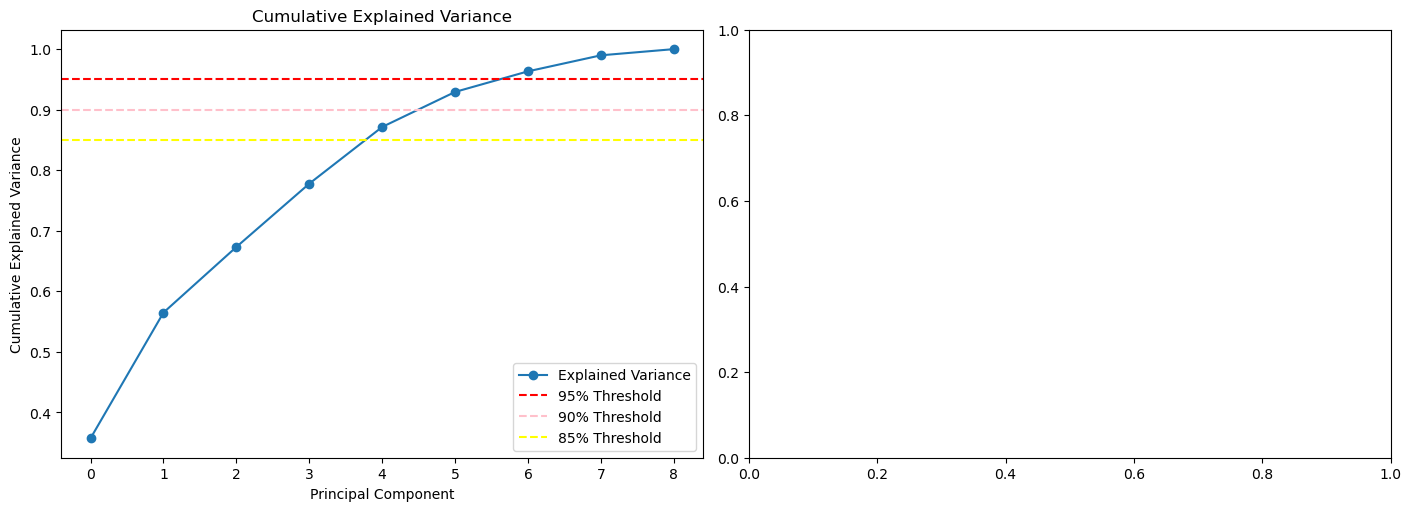

In [59]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

# First plot: Cumulative explained variance
axes[0].plot(
    range(len(songs5000_pca.explained_variance_ratio_)),
    np.cumsum(songs5000_pca.explained_variance_ratio_),
    marker="o",
    label="Explained Variance",
)
axes[0].axhline(y=0.95, color="red", linestyle="--", label="95% Threshold")
axes[0].axhline(y=0.90, color="pink", linestyle="--", label="90% Threshold")
axes[0].axhline(y=0.85, color="yellow", linestyle="--", label="85% Threshold")
axes[0].set_title("Cumulative Explained Variance")
axes[0].set_xlabel("Principal Component")
axes[0].set_ylabel("Cumulative Explained Variance")
axes[0].legend()

# Second plot: Alt cumulative explained variance
# axes[1].plot(
#     range(len(songs5000_pca_alt.explained_variance_ratio_)),
#     np.cumsum(songs5000_pca_alt.explained_variance_ratio_),
#     marker="o",
#     label="Explained Variance",
# )
# axes[1].axhline(y=0.95, color="red", linestyle="--", label="95% Threshold")
# axes[1].axhline(y=0.90, color="pink", linestyle="--", label="90% Threshold")
# axes[1].axhline(y=0.85, color="yellow", linestyle="--", label="85% Threshold")
# axes[1].set_title("Alt Cumulative Explained Variance")
# axes[1].set_xlabel("Principal Component")
# axes[1].set_ylabel("Cumulative Explained Variance")
# axes[1].legend()

# Show the combined plots
plt.show()


Recap

10 clusters explain 95% of the variance

7 clusters explain almost 90% of the variance - it's our number

6 clusters explain 85% of the variance

# 3 Number of clusters

In [36]:
number_of_components = 7
songs5000_processed1_df = songs5000_pca_df.iloc[:, :number_of_components].copy()

In [ ]:
# For loop with a few iterations per each "k"
# Around 0.5 seconds per 1 "k" and per 1 iteration
# A run takes (max_k - min_k) * iterations_per_seed * 0.75 / 60 minutes

# Parameters
seed = 123
min_k = 2
max_k = 20
iterations_per_seed = 10
ch_scores = []
db_scores = []
inertia_list = []
sil_scores = []

# Generate x random seeds
random.seed(seed)
random_seeds = [random.randint(0, 10000) for _ in range(iterations_per_seed)]

# Iterations
for k in range(min_k, max_k):
    ch_score_in_iteration = []
    db_score_in_iteration = []
    inertia_in_iteration = []
    sil_score_in_iteration = []
    
    for rnd_seed in random_seeds:
        k_means = KMeans(n_clusters=k, n_init="auto", random_state=rnd_seed)
        k_means.fit(songs5000_processed1_df)
        
        # Calculate Calinski-Harabasz score, Davies-Bouldin score, inertia and silhouette score
        labels = k_means.labels_
        
        ch_score = calinski_harabasz_score(songs5000_processed1_df, labels)
        ch_score_in_iteration.append(ch_score)
        
        db_score = davies_bouldin_score(songs5000_processed1_df, labels)
        db_score_in_iteration.append(db_score)
        
        inertia_in_iteration.append(k_means.inertia_)
        
        sil_score = silhouette_score(songs5000_processed1_df, labels)
        sil_score_in_iteration.append(sil_score)
    
    # Append averages to the final lists
    ch_scores.append(pd.Series(ch_score_in_iteration).mean())
    db_scores.append(pd.Series(db_score_in_iteration).mean())
    inertia_list.append(pd.Series(inertia_in_iteration).mean())
    sil_scores.append(pd.Series(sil_score_in_iteration).mean())

_ = ctypes.windll.kernel32.Beep(1000, 2000)

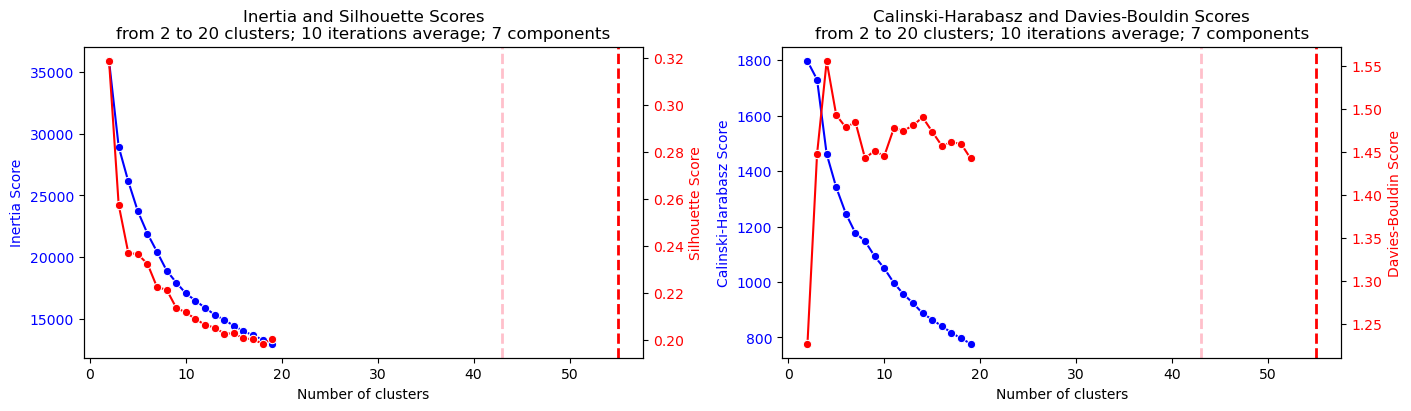

In [12]:
# Assuming inertia_list, sil_scores, ch_scores, db_scores, min_k, and max_k are defined

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 4), constrained_layout=True)

# First subplot: Inertia and Silhouette Scores
ax1 = axes[0]
sns.lineplot(x=range(min_k, max_k), y=inertia_list, marker='o', ax=ax1, label="Inertia Score", color='b', legend=False)
ax1.set_xlabel("Number of clusters")
ax1.set_ylabel("Inertia Score", color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax1_2 = ax1.twinx()
sns.lineplot(x=range(min_k, max_k), y=sil_scores, marker='o', ax=ax1_2, label="Silhouette Score", color='r', legend=False)
ax1_2.set_ylabel("Silhouette Score", color='r')
ax1_2.tick_params(axis='y', labelcolor='r')

ax1.set_title(f"Inertia and Silhouette Scores\nfrom {min_k} to {max_k} clusters; {iterations_per_seed} iterations average; {number_of_components} components")
ax1.axvline(x=43, color='pink', linestyle='--', linewidth=2)
ax1.axvline(x=55, color='red', linestyle='--', linewidth=2)

# Second subplot: Calinski-Harabasz and Davies-Bouldin Scores
ax2 = axes[1]
sns.lineplot(x=range(min_k, max_k), y=ch_scores, marker='o', ax=ax2, label="Calinski-Harabasz Score", color='b', legend=False)
ax2.set_xlabel("Number of clusters")
ax2.set_ylabel("Calinski-Harabasz Score", color='b')
ax2.tick_params(axis='y', labelcolor='b')

ax2_2 = ax2.twinx()
sns.lineplot(x=range(min_k, max_k), y=db_scores, marker='o', ax=ax2_2, label="Davies-Bouldin Score", color='r', legend=False)
ax2_2.set_ylabel("Davies-Bouldin Score", color='r')
ax2_2.tick_params(axis='y', labelcolor='r')

ax2.set_title(f"Calinski-Harabasz and Davies-Bouldin Scores\nfrom {min_k} to {max_k} clusters; {iterations_per_seed} iterations average; {number_of_components} components")
ax2.axvline(x=43, color='pink', linestyle='--', linewidth=2)
ax2.axvline(x=55, color='red', linestyle='--', linewidth=2)

# Add legends to the figure
# fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=2)

# Show the combined plots
plt.show()

In [102]:
number_of_kmeans = 5

# 4 K-means

In [103]:
if 'cluster' in songs5000_processed1_df.columns:
    songs5000_processed1_df = songs5000_processed1_df.drop(columns='cluster')
kmeans = KMeans(n_clusters = number_of_kmeans, random_state = 123)
kmeans.fit(songs5000_processed1_df)
clusters = kmeans.labels_
songs5000_processed1_df["cluster"] = clusters
# songs5000_processed1_df

# 5 Charts

In [39]:
scatter_objects = []
categories = songs5000_processed1_df.drop(columns=['cluster']).columns

# Iterate over the unique clusters and add an object for each cluster to the list
for cluster in sorted(songs5000_processed1_df['cluster'].unique()):

  # Find the mean value for each column of the cluster
  cluster_min = [songs5000_processed1_df.loc[songs5000_processed1_df["cluster"] == cluster, category].min() for category in categories]
  cluster_scatter = go.Scatterpolar(r = cluster_min, theta = categories, fill = 'toself', name = f'Cluster {cluster}')
  scatter_objects.append(cluster_scatter)

# Create the figure (the white area)
fig = go.Figure()
fig.add_traces(scatter_objects)

# Add extras to the plot, such as title
fig.update_layout(
  title_text = 'Radar chart of MIN by cluster',
  height = 600,
  width = 800,
  polar = dict(radialaxis = dict(visible = True, range = [-3, 3])),
  showlegend = True
)

fig.show()

In [40]:
scatter_objects = []
categories = songs5000_processed1_df.drop(columns=['cluster']).columns

# Iterate over the unique clusters and add an object for each cluster to the list
for cluster in sorted(songs5000_processed1_df['cluster'].unique()):

  # Find the mean value for each column of the cluster
  cluster_means = [songs5000_processed1_df.loc[songs5000_processed1_df["cluster"] == cluster, category].mean() for category in categories]
  cluster_scatter = go.Scatterpolar(r = cluster_means, theta = categories, fill = 'toself', name = f'Cluster {cluster}')
  scatter_objects.append(cluster_scatter)

# Create the figure (the white area)
fig = go.Figure()
fig.add_traces(scatter_objects)

# Add extras to the plot, such as title
fig.update_layout(
  title_text = 'Radar chart of MEAN by cluster',
  height = 600,
  width = 800,
  polar = dict(radialaxis = dict(visible = True, range = [-3, 3])),
  showlegend = True
)

fig.show()

In [41]:
scatter_objects = []
categories = songs5000_processed1_df.drop(columns=['cluster']).columns

# Iterate over the unique clusters and add an object for each cluster to the list
for cluster in sorted(songs5000_processed1_df['cluster'].unique()):

  # Find the mean value for each column of the cluster
  cluster_max = [songs5000_processed1_df.loc[songs5000_processed1_df["cluster"] == cluster, category].max() for category in categories]
  cluster_scatter = go.Scatterpolar(r = cluster_max, theta = categories, fill = 'toself', name = f'Cluster {cluster}')
  scatter_objects.append(cluster_scatter)

# Create the figure (the white area)
fig = go.Figure()
fig.add_traces(scatter_objects)

# Add extras to the plot, such as title
fig.update_layout(
  title_text = 'Radar chart of MAX by cluster',
  height = 600,
  width = 800,
  polar = dict(radialaxis = dict(visible = True, range = [-3, 10])),
  showlegend = True
)

fig.show()

In [104]:
songs5000_processed1_chart_df = songs5000_processed1_df.loc[songs5000_processed1_df['cluster'].isin(random.sample(list(songs5000_processed1_df['cluster'].values), 100))].copy()
# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=songs5000_processed1_chart_df.iloc[:, 0],  # X-axis
    y=songs5000_processed1_chart_df.iloc[:, 1],  # Y-axis
    z=songs5000_processed1_chart_df.iloc[:, 2],  # Z-axis
    mode='markers',  # Show data points as markers
    marker=dict(
        color=songs5000_processed1_chart_df.loc[:, 'cluster'],  # Color by KMeans labels
        colorscale='turbo',  # Use the 'Viridis' color scale
        size=2,  # Marker size
        opacity=0.8  # Marker opacity
    )
)])

cluster_centers = songs5000_processed1_chart_df.groupby('cluster').agg({songs5000_processed1_chart_df.columns[0]: 'mean',
                                                                        songs5000_processed1_chart_df.columns[1]: 'mean',
                                                                        songs5000_processed1_chart_df.columns[2]: 'mean'}).reset_index()

for idx, row in cluster_centers.iterrows():
    fig.add_trace(go.Scatter3d(
        x=[row[songs5000_processed1_chart_df.columns[0]]],
        y=[row[songs5000_processed1_chart_df.columns[1]]],
        z=[row[songs5000_processed1_chart_df.columns[2]]],
        mode='text',  # Mode is 'text' to just add a label
        text=[f"Cluster {int(row['cluster'])}"],  # Cluster label
        textposition='top center',  # Position of the label
        textfont=dict(size=12, color='black'),  # Font size and color
    ))

# Update layout with axis labels and title
fig.update_layout(
    title='KMeans Clustering in 3D',
    scene=dict(
        xaxis_title=songs5000_processed1_chart_df.columns[0],  # Label for X-axis
        yaxis_title=songs5000_processed1_chart_df.columns[1],  # Label for Y-axis
        zaxis_title=songs5000_processed1_chart_df.columns[2]   # Label for Z-axis
    ),
    margin=dict(l=0, r=0, b=0, t=40),  # Adjust the margins as needed
    width = 900,
    height = 800
)

# Show the plot
fig.show()


# 6 Songs

In [105]:
songs5000_1_df = songs5000_processed1_df.sort_values(by="cluster").join(songs5000_names_df) # .drop(columns=['html'])
(pd.DataFrame(songs5000_1_df
              .groupby('cluster')
              .size()
              .rename('tracks')).sort_values('tracks').reset_index())

,cluster,tracks
0,3,365
1,1,841
2,0,1018
3,4,1190
4,2,1746


In [106]:
songs5000_1_df.loc[songs5000_1_df['cluster'] == 0, ['cluster', 'artist', 'name', 'html']].sort_values(['artist', 'name'])

,cluster,artist,name,html
id,,,,
2yiZyjMEByt9sJBZWnWaDR,0,*NSYNC,Bye Bye Bye ...,https://open.spotify.com/track/2yiZyjMEByt9sJB...
4EF941VzqGMLFnYlXH03hG,0,2PM,Make it ...,https://open.spotify.com/track/4EF941VzqGMLFnY...
2MQ51y5NhCyva4SgWmK2Me,0,2Pac,Ghetto Gospel ...,https://open.spotify.com/track/2MQ51y5NhCyva4S...
7f0jXNMu2xjQUtmKMuWhGA,0,4 Non Blondes,What's Up? ...,https://open.spotify.com/track/7f0jXNMu2xjQUtm...
1JRK7srBWUtAW7dPabKBwJ,0,5 Seconds of Summer,Teeth ...,https://open.spotify.com/track/1JRK7srBWUtAW7d...
...,...,...,...,...
2WfaOiMkCvy7F5fcp2zZ8L,0,a-ha,Take on Me ...,https://open.spotify.com/track/2WfaOiMkCvy7F5f...
2zrhoHlFKxFTRF5aMyxMoQ,0,aespa,Next Level ...,https://open.spotify.com/track/2zrhoHlFKxFTRF5...
7aiClxsDWFRQ0Kzk5KI5ku,0,blackbear,hot girl bummer ...,https://open.spotify.com/track/7aiClxsDWFRQ0Kz...


# 7 Subclusters

## 7.1 Blue cluster (#1)

In [82]:
songs5000_processed_sub1_df = songs5000_processed1_df.loc[songs5000_processed1_df['cluster'] == 1, :].copy()

In [ ]:
# For loop with a few iterations per each "k"
# Around 0.5 seconds per 1 "k" and per 1 iteration
# A run takes (max_k - min_k) * iterations_per_seed * 0.75 / 60 minutes

# Parameters
seed = 123
min_k = 2
max_k = 20
iterations_per_seed = 1
ch_scores = []
db_scores = []
inertia_list = []
sil_scores = []

# Generate x random seeds
random.seed(seed)
random_seeds = [random.randint(0, 10000) for _ in range(iterations_per_seed)]

# Iterations
for k in range(min_k, max_k):
    ch_score_in_iteration = []
    db_score_in_iteration = []
    inertia_in_iteration = []
    sil_score_in_iteration = []
    
    for rnd_seed in random_seeds:
        k_means = KMeans(n_clusters=k, n_init="auto", random_state=rnd_seed)
        k_means.fit(songs5000_processed_sub1_df)
        
        # Calculate Calinski-Harabasz score, Davies-Bouldin score, inertia and silhouette score
        labels = k_means.labels_
        
        ch_score = calinski_harabasz_score(songs5000_processed_sub1_df, labels)
        ch_score_in_iteration.append(ch_score)
        
        db_score = davies_bouldin_score(songs5000_processed_sub1_df, labels)
        db_score_in_iteration.append(db_score)
        
        inertia_in_iteration.append(k_means.inertia_)
        
        sil_score = silhouette_score(songs5000_processed_sub1_df, labels)
        sil_score_in_iteration.append(sil_score)
    
    # Append averages to the final lists
    ch_scores.append(pd.Series(ch_score_in_iteration).mean())
    db_scores.append(pd.Series(db_score_in_iteration).mean())
    inertia_list.append(pd.Series(inertia_in_iteration).mean())
    sil_scores.append(pd.Series(sil_score_in_iteration).mean())

_ = ctypes.windll.kernel32.Beep(1000, 2000)

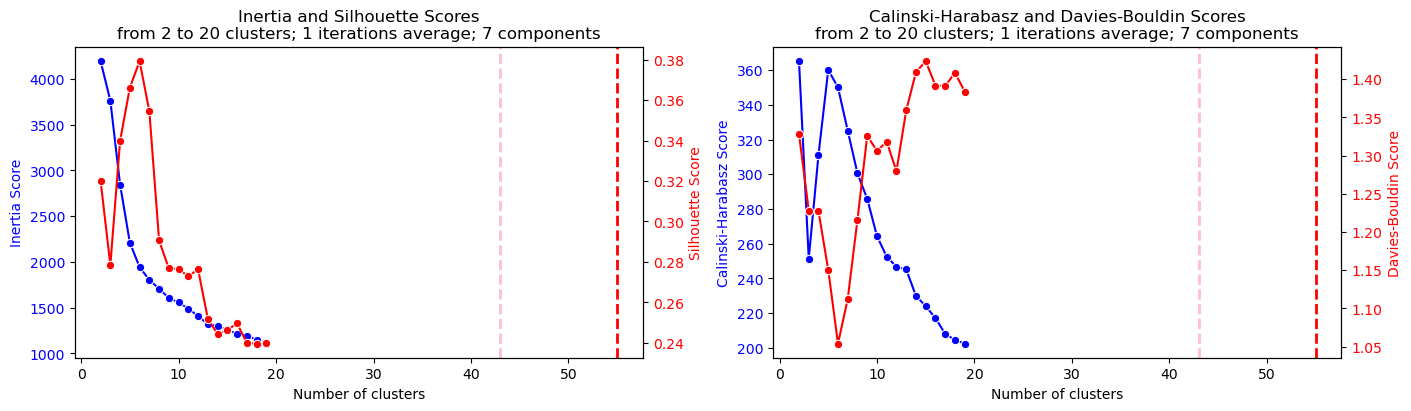

In [90]:
# Assuming inertia_list, sil_scores, ch_scores, db_scores, min_k, and max_k are defined

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 4), constrained_layout=True)

# First subplot: Inertia and Silhouette Scores
ax1 = axes[0]
sns.lineplot(x=range(min_k, max_k), y=inertia_list, marker='o', ax=ax1, label="Inertia Score", color='b', legend=False)
ax1.set_xlabel("Number of clusters")
ax1.set_ylabel("Inertia Score", color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax1_2 = ax1.twinx()
sns.lineplot(x=range(min_k, max_k), y=sil_scores, marker='o', ax=ax1_2, label="Silhouette Score", color='r', legend=False)
ax1_2.set_ylabel("Silhouette Score", color='r')
ax1_2.tick_params(axis='y', labelcolor='r')

ax1.set_title(f"Inertia and Silhouette Scores\nfrom {min_k} to {max_k} clusters; {iterations_per_seed} iterations average; {number_of_components} components")
ax1.axvline(x=43, color='pink', linestyle='--', linewidth=2)
ax1.axvline(x=55, color='red', linestyle='--', linewidth=2)

# Second subplot: Calinski-Harabasz and Davies-Bouldin Scores
ax2 = axes[1]
sns.lineplot(x=range(min_k, max_k), y=ch_scores, marker='o', ax=ax2, label="Calinski-Harabasz Score", color='b', legend=False)
ax2.set_xlabel("Number of clusters")
ax2.set_ylabel("Calinski-Harabasz Score", color='b')
ax2.tick_params(axis='y', labelcolor='b')

ax2_2 = ax2.twinx()
sns.lineplot(x=range(min_k, max_k), y=db_scores, marker='o', ax=ax2_2, label="Davies-Bouldin Score", color='r', legend=False)
ax2_2.set_ylabel("Davies-Bouldin Score", color='r')
ax2_2.tick_params(axis='y', labelcolor='r')

ax2.set_title(f"Calinski-Harabasz and Davies-Bouldin Scores\nfrom {min_k} to {max_k} clusters; {iterations_per_seed} iterations average; {number_of_components} components")
ax2.axvline(x=43, color='pink', linestyle='--', linewidth=2)
ax2.axvline(x=55, color='red', linestyle='--', linewidth=2)

# Add legends to the figure
# fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=2)

# Show the combined plots
plt.show()

In [91]:
number_of_kmeans = 12

In [92]:
if 'cluster' in songs5000_processed_sub1_df.columns:
    songs5000_processed_sub1_df = songs5000_processed_sub1_df.drop(columns='cluster')
kmeans = KMeans(n_clusters = number_of_kmeans, random_state = 123)
kmeans.fit(songs5000_processed_sub1_df)
subclusters = kmeans.labels_
songs5000_processed_sub1_df["cluster"] = 1
songs5000_processed_sub1_df["subcluster"] = subclusters
# songs5000_processed_sub1_df

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.



In [93]:
songs5000_processed_sub1_chart_df = songs5000_processed_sub1_df.loc[songs5000_processed_sub1_df['cluster'].isin(random.sample(list(songs5000_processed_sub1_df['cluster'].values), 100))].copy()
# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=songs5000_processed_sub1_chart_df.iloc[:, 0],  # X-axis
    y=songs5000_processed_sub1_chart_df.iloc[:, 1],  # Y-axis
    z=songs5000_processed_sub1_chart_df.iloc[:, 2],  # Z-axis
    mode='markers',  # Show data points as markers
    marker=dict(
        color=songs5000_processed_sub1_chart_df.loc[:, 'subcluster'],  # Color by KMeans labels
        colorscale='turbo',  # Use the 'Viridis' color scale
        size=2,  # Marker size
        opacity=0.8  # Marker opacity
    )
)])

cluster_centers = songs5000_processed_sub1_chart_df.groupby('subcluster').agg({songs5000_processed_sub1_chart_df.columns[0]: 'mean',
                                                                        songs5000_processed_sub1_chart_df.columns[1]: 'mean',
                                                                        songs5000_processed_sub1_chart_df.columns[2]: 'mean'}).reset_index()

for idx, row in cluster_centers.iterrows():
    fig.add_trace(go.Scatter3d(
        x=[row[songs5000_processed_sub1_chart_df.columns[0]]],
        y=[row[songs5000_processed_sub1_chart_df.columns[1]]],
        z=[row[songs5000_processed_sub1_chart_df.columns[2]]],
        mode='text',  # Mode is 'text' to just add a label
        text=[f"Cluster {int(row['subcluster'])}"],  # Cluster label
        textposition='top center',  # Position of the label
        textfont=dict(size=12, color='black'),  # Font size and color
    ))

# Update layout with axis labels and title
fig.update_layout(
    title='KMeans Clustering in 3D',
    scene=dict(
        xaxis_title=songs5000_processed_sub1_chart_df.columns[0],  # Label for X-axis
        yaxis_title=songs5000_processed_sub1_chart_df.columns[1],  # Label for Y-axis
        zaxis_title=songs5000_processed_sub1_chart_df.columns[2]   # Label for Z-axis
    ),
    margin=dict(l=0, r=0, b=0, t=40),  # Adjust the margins as needed
    width = 900,
    height = 800
)

# Show the plot
fig.show()


In [94]:
songs5000_sub1_df = songs5000_processed_sub1_df.sort_values(by="subcluster")#.join(songs5000_names_df) # .drop(columns=['html'])
(pd.DataFrame(songs5000_sub1_df
              .groupby(['cluster', 'subcluster'])
              .size()
              .rename('tracks')).sort_values('tracks').reset_index())

,cluster,subcluster,tracks
0,1,10,13
1,1,6,21
2,1,4,46
3,1,2,56
4,1,9,56
5,1,3,64
6,1,0,66
7,1,11,77
8,1,1,87
9,1,7,87


In [88]:
songs5000_sub1_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 841 entries, 6g4dvPG9jMtSCwQKIHOvo4  to 606R1WLtU2hPgl0YNfSJ4j 
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pca0        841 non-null    float64
 1   pca1        841 non-null    float64
 2   pca2        841 non-null    float64
 3   pca3        841 non-null    float64
 4   pca4        841 non-null    float64
 5   pca5        841 non-null    float64
 6   pca6        841 non-null    float64
 7   cluster     841 non-null    int64  
 8   subcluster  841 non-null    int32  
dtypes: float64(7), int32(1), int64(1)
memory usage: 62.4+ KB
